<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Решающее-дерево" data-toc-modified-id="Решающее-дерево-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Решающее дерево</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LGBMRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

warnings.filterwarnings("ignore")

In [2]:
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
taxi.sort_index(inplace=True)
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
taxi.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [4]:
display(taxi.head(7))

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7


<AxesSubplot:xlabel='datetime'>

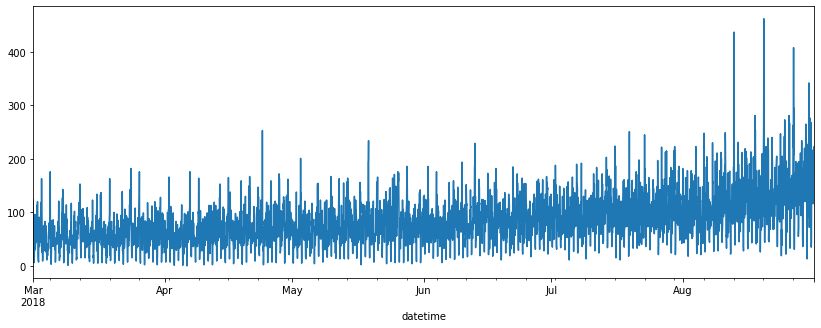

In [5]:
taxi = taxi.resample('1H').sum()
taxi['num_orders'].plot(figsize=(14,5))

## Анализ

Text(0, 0.5, 'Количество заказов в час')

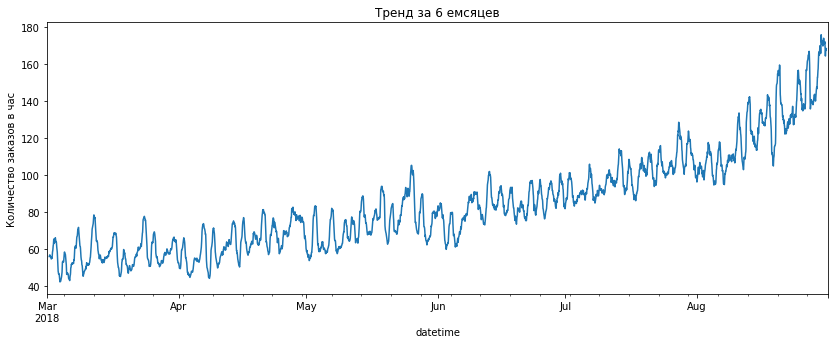

In [6]:
decomposed = seasonal_decompose(taxi)
plt.figure(figsize=(14, 5))
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд за 6 емсяцев')
plt.ylabel('Количество заказов в час')

По графику виден растущий тренд, значит временной ряд не является стационарным.

Text(0.5, 1.0, 'Сезонность по часам')

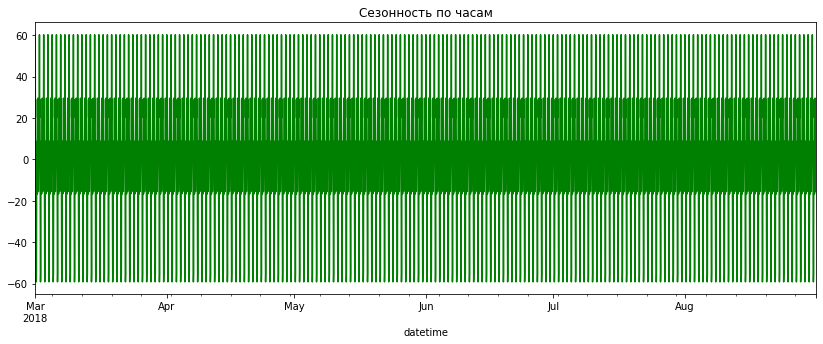

In [7]:
plt.figure(figsize=(14, 5))
decomposed.seasonal.plot(ax=plt.gca(),color='g')
plt.title('Сезонность по часам')

Text(0.5, 1.0, 'Остаток')

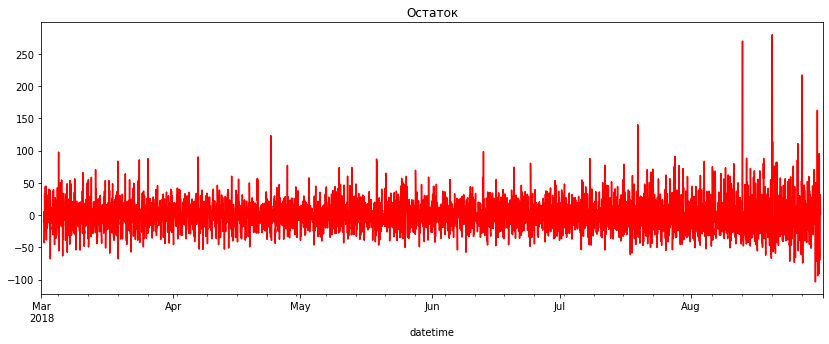

In [8]:
plt.figure(figsize=(14, 5))
decomposed.resid.plot(ax=plt.gca(), color='r')
plt.title('Остаток')

Тренд, сезонность и остаток декомпозиции лучше рассматривать на отдельно взятой неделе.

Text(0.5, 1.0, 'Residuals 09.07.2018 по 16.07.2018')

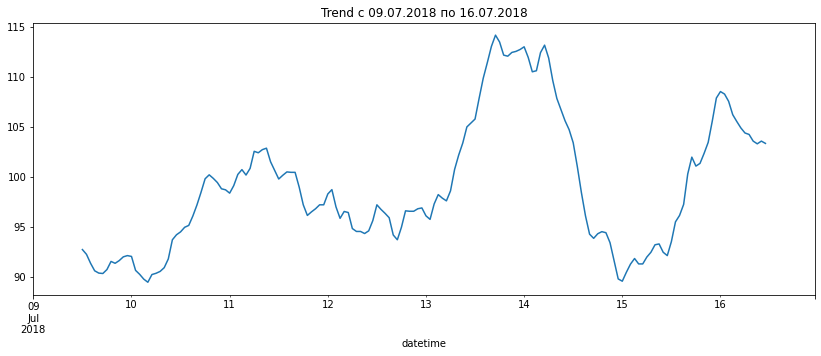

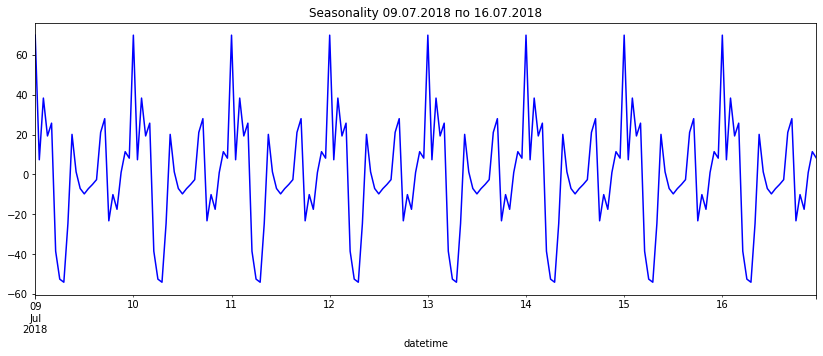

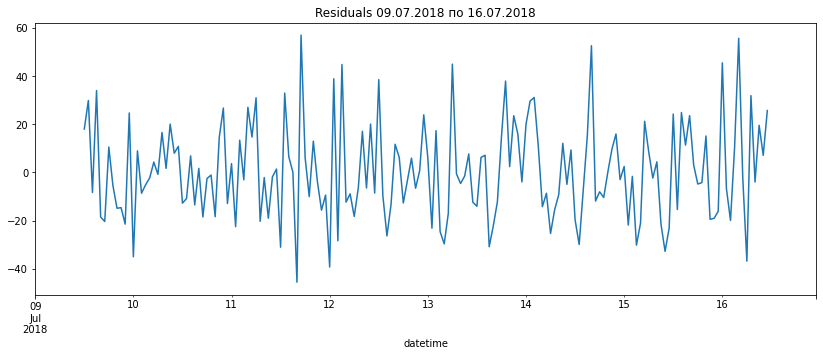

In [9]:
same_week = seasonal_decompose(taxi['2018-07-09':'2018-07-16'])

plt.figure(figsize=(14,5))
same_week.trend.plot(ax=plt.gca())
plt.title('Trend с 09.07.2018 по 16.07.2018')

plt.figure(figsize=(14,5))
same_week.seasonal.plot(ax=plt.gca(),color='b')
plt.title('Seasonality 09.07.2018 по 16.07.2018')

plt.figure(figsize=(14,5))
same_week.resid.plot(ax=plt.gca())
plt.title('Residuals 09.07.2018 по 16.07.2018')

Наблюдается рост количества заказов вечером и к полуночи, а также спад заказов к утру.  

Можно заметить значительное увеличение заказов в пятницу после полудня до начала субботы.  

Создам новые признаки в данных. С каждым месяцем количество заказов растет, добавлю месяц.  В течении недели меняется количество заказов, потому добавлю день и день недели.  

Создание отстающих на 48 часов признаки и скользящего среднего за 5 часов

In [10]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

taxi_new = make_features(taxi, 48, 5)

taxi_new.tail(3)

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-31 21:00:00,159,8,31,4,154.0,136.0,207.0,217.0,197.0,116.0,...,56.0,186.0,193.0,232.0,217.0,216.0,265.0,177.0,170.0,182.2
2018-08-31 22:00:00,223,8,31,4,159.0,154.0,136.0,207.0,217.0,197.0,...,13.0,56.0,186.0,193.0,232.0,217.0,216.0,265.0,177.0,174.6
2018-08-31 23:00:00,205,8,31,4,223.0,159.0,154.0,136.0,207.0,217.0,...,39.0,13.0,56.0,186.0,193.0,232.0,217.0,216.0,265.0,175.8


**Вывод**  

Были выявлены некоторые закономерности, добавлены необходимые признаки для прогнозирования и обучения работы моделей.

## Обучение

Разделение на выборки

In [11]:
taxi_tr, taxi_test = train_test_split(taxi_new, shuffle=False, test_size=0.1)
taxi_train, taxi_valid = train_test_split(taxi_tr, shuffle=False, test_size=1/9)

print('Размер обучающей выборки:', taxi_train.shape)
print('Размер валидационной выборки:', taxi_valid.shape)
print('Размер тестовой выборки:', taxi_test.shape)

Размер обучающей выборки: (3532, 53)
Размер валидационной выборки: (442, 53)
Размер тестовой выборки: (442, 53)


Удаление пропусков в выборках и выделение целевого признака

In [12]:
taxi_train = taxi_train.dropna()
taxi_valid = taxi_valid.dropna()
taxi_test = taxi_test.dropna()

features_train = taxi_train.drop(['num_orders'], axis=1)
target_train = taxi_train['num_orders']

features_valid = taxi_valid.drop(['num_orders'], axis=1)
target_valid = taxi_valid['num_orders']

features_test = taxi_test.drop(['num_orders'], axis=1)
target_test = taxi_test['num_orders']

model_score = {}

### Линейная регрессия

In [13]:
model = LinearRegression()
model = model.fit(features_train, target_train)
predictions = model.predict(features_train)
mse1 = mean_squared_error(target_train, predictions)
rmse_train1 = mse1 ** 0.5

predictions_valid = model.predict(features_valid)
mse_valid1 = mean_squared_error(target_valid, predictions_valid)
rmse_valid1 = mse_valid1 ** 0.5

predictions_test1 = model.predict(features_test)
mse_test1 = mean_squared_error(target_test, predictions_test1)
rmse_test1 = mse_test1 ** 0.5

print('RMSE обучающей выборки:', rmse_train1)
print("RMSE валидационной выборки: ", rmse_valid1)
print('RMSE тестовой выборки:', rmse_test1)

RMSE обучающей выборки: 22.126810696511416
RMSE валидационной выборки:  31.640793842435528
RMSE тестовой выборки: 44.07191983195077


Text(0.5, 1.0, 'Визуализация исходного и предсказанного рядов модели LinearRegression')

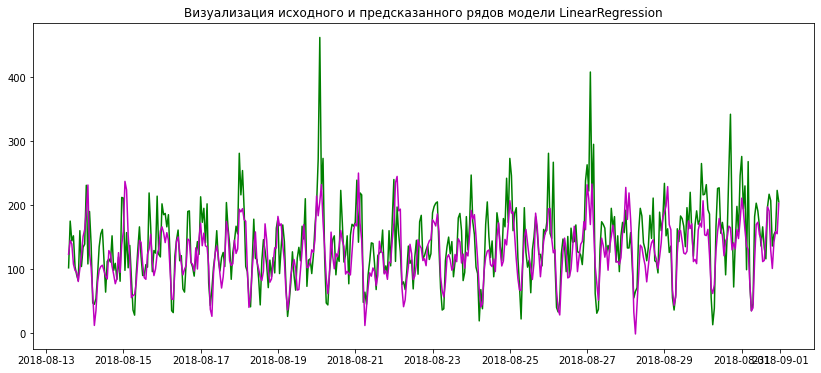

In [14]:
plt.figure(figsize=(14,6))
plt.plot(target_test.index, target_test, 'g-', target_test.index, predictions_test1,'m-')
plt.title('Визуализация исходного и предсказанного рядов модели LinearRegression')

In [15]:
model_score['LinearRegression'] = [rmse_train1, rmse_valid1, rmse_test1]

### Решающее дерево

In [16]:
for depth in range(5, 8): #range(1, 20):
    model = DecisionTreeRegressor(max_depth=depth, random_state=12345)
    model = model.fit(features_train, target_train)
    predictions = model.predict(features_train)
    mse2 = mean_squared_error(target_train, predictions)
    rmse_train2 = mse2 ** 0.5
    
    predictions_valid = model.predict(features_valid)
    mse_valid2 = mean_squared_error(target_valid, predictions_valid)
    rmse_valid2= mse_valid2 ** 0.5
    
    print("max_depth =", depth, ":")
    print("RMSE обучающей выборки:", rmse_train2)
    print("RMSE валидационной выборки", rmse_valid2)
    print()

max_depth = 5 :
RMSE обучающей выборки: 22.366426474330463
RMSE валидационной выборки 38.6640845985702

max_depth = 6 :
RMSE обучающей выборки: 20.789246137538424
RMSE валидационной выборки 37.327780987533835

max_depth = 7 :
RMSE обучающей выборки: 18.96361298605987
RMSE валидационной выборки 38.01056029919611



In [17]:
model_tree = DecisionTreeRegressor(max_depth=6, random_state=12345)
model_tree = model_tree.fit(features_train, target_train)
predictions2 = model_tree.predict(features_test)
mse2 = mean_squared_error(target_test, predictions2)
rmse_test2 = mse2 ** 0.5
print("RMSE обучающей выборки", rmse_test2)

RMSE обучающей выборки 57.003883537960114


Text(0.5, 1.0, 'Визуализация исходного и предсказанного рядов модели DecisionTreeRegressor')

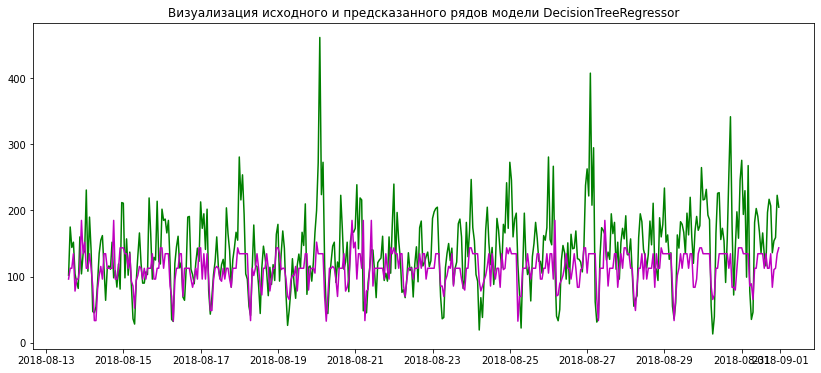

In [18]:
plt.figure(figsize=(14,6))
plt.plot(target_test.index, target_test, 'g-', target_test.index, predictions2,'m-')
plt.title('Визуализация исходного и предсказанного рядов модели DecisionTreeRegressor')

In [19]:
model_score['DecisionTreeRegressor'] = [rmse_train2, rmse_valid2, rmse_test2]

### CatBoostRegressor

In [20]:
model = CatBoostRegressor(random_state = 12345)
hyperparams = [{'depth' : [5], #[1, 2, 3, 4, 5, 6, 7, 8],
                'learning_rate' : [0.1], #[0.03, 0.06, 0.1, 0.3, 0.5],
                'iterations' : [300], #[100, 200, 300],
                'verbose' : [False]
               }]

cv3 = TimeSeriesSplit(n_splits=3).split(features_train)
cbr_model = GridSearchCV(model, hyperparams, cv=cv3, scoring='neg_mean_squared_error')
cbr_model.fit(features_train, target_train)
target_predict3 = cbr_model.predict(features_test)
best_params = cbr_model.best_params_
print(best_params)

rmse_train3 = (cbr_model.best_score_*-1)**0.5
print('RMSE на обучающей выборке:', rmse_train3)

{'depth': 5, 'iterations': 300, 'learning_rate': 0.1, 'verbose': False}
RMSE на обучающей выборке: 23.068293255837972


In [21]:
valid_model = GridSearchCV(model, hyperparams, scoring='neg_mean_squared_error')
test_model = GridSearchCV(model, hyperparams, scoring='neg_mean_squared_error')
valid_model.fit(features_valid, target_valid)
test_model.fit(features_test, target_test)
rmse_valid3 = (valid_model.best_score_*(-1))**0.5
rmse_test3 = (test_model.best_score_*(-1))**0.5
print('RMSE на валидационной выборке:', rmse_valid3)
print('RMSE на тестовой выборке:', rmse_test3)

RMSE на валидационной выборке: 33.13631904305712
RMSE на тестовой выборке: 40.53221777075021


In [22]:
model_score['CatBoostRegressor'] = [rmse_train3, rmse_valid3, rmse_test3]

### LGBMRegressor

In [23]:
parameters = {'max_depth': [9], #range(1, 19),
              'n_estimators': [40] #range(10, 40)
             }
lgb_gs = GridSearchCV(LGBMRegressor(random_state=12345), 
                      parameters,
                      cv=KFold(n_splits=10, shuffle=True, random_state=12345),
                      scoring='neg_mean_squared_error')

lgb_gs.fit(features_train, target_train)
target_predict4 = lgb_gs.predict(features_test)
print(lgb_gs.best_params_)
rmse_train4 = (lgb_gs.best_score_*-1)**0.5
print('RMSE на обучающей выборке:', rmse_train4)

{'max_depth': 9, 'n_estimators': 40}
RMSE на обучающей выборке: 21.373398677793666


In [24]:
lgb_gs = GridSearchCV(LGBMRegressor(random_state=12345), 
                     {'max_depth':[9],
                      'n_estimators':[40]},
                      cv=KFold(n_splits=10, shuffle=True, random_state=12345),
                      scoring='neg_mean_squared_error')

lgb_gs.fit(features_valid, target_valid)
rmse_valid4 = (lgb_gs.best_score_*(-1))**0.5
print('RMSE на валидационной выборке:', rmse_valid4)

lgb_gs.fit(features_test, target_test)
rmse_test4 = (lgb_gs.best_score_*(-1))**0.5
print('RMSE на тестовой выборке:', rmse_test4)

RMSE на валидационной выборке: 32.69769734186719
RMSE на тестовой выборке: 42.88218467863323


In [25]:
model_score['LGBMRegressor'] = [rmse_train4, rmse_valid4, rmse_test4]

## Тестирование

In [26]:
taxi_score = pd.DataFrame.from_dict(data=model_score, columns=['RMSE train', 'RMSE valid', 'RMSE test'], orient='index')
display(taxi_score)

,RMSE train,RMSE valid,RMSE test
LinearRegression,22.126811,31.640794,44.071920
DecisionTreeRegressor,18.963613,38.010560,57.003884
CatBoostRegressor,23.068293,33.136319,40.532218
LGBMRegressor,21.373399,32.697697,42.882185


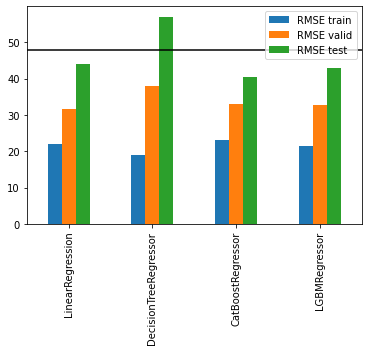

In [27]:
taxi_score.plot.bar(stacked=False).hlines(48, -5, 10, color='k')

В данной работе было:  
- Проведено ресемплирование временного ряда.  
- Проанализированы данные на сезонность и тренд как всего объема данных, так и отдельно взятой недели, выявлены закономерности.  
- Добавлены отстающие признаки, скользящего среднего и признаки даты
- Обучены модели различных регрессий, найдена метрика RMSE на обучающей, тестовой и валидационной выборках.

**Вывод**  

Лучшее показание метрики RMSE показала модель **CatBoostRegressor** (ошибка в 40-41 машину в час).  
Чуть хуже - *LGBMRegressor* (ошибка в 43 машины в час)